In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.font_manager import FontProperties

import os,json

In [13]:
def collect_across_reps( res_root_dir = None ,train_ratios = [0.05,0.25,0.5],\
    eval_ratios = [0.05,0.25,0.5,0.75,0.95],num_train_datas = [25,50,100,200,400],rep_inds = [0,1], \
    strategies = [ 'opposite',], multi_task = False, random_init = False, aux_ratios = None, \
    triplet = False, average = False):
    
    all_reps ={}
    for rep_i in rep_inds:
        print (rep_i)
        best_sent_accs = {(t_r,e_r):{n:{}  for n in num_train_datas} for e_r in eval_ratios for t_r in train_ratios}
        for n in num_train_datas:
            for t_r in train_ratios:
                try:
                    bert_results_sent= json.load(open( os.path.join(res_root_dir,'rep_'+str(rep_i), 'finetune_result_train_ratio_{}_{}_num_labeled_{}'.format(t_r, 'pred_sent', n) +'/finetune_final_results.json') ))
                except:
#                     print ('cound not find {} {} {}'.format(rep_i, n, t_r))
                    continue
                bert_results_sent = list(bert_results_sent.values())

                bert_results_sent_twice= json.load(open( os.path.join(res_root_dir,'rep_'+str(rep_i), 'finetune_result_train_ratio_{}_{}_num_labeled_{}'.format(t_r, 'pred_sent', 2 * n) +'/finetune_final_results.json') ))
                bert_results_sent_twice = list(bert_results_sent_twice.values())
                
                if random_init:
                    bert_results_sent_init= json.load(open( os.path.join(res_root_dir,'rep_'+str(rep_i), 'finetune_result_train_ratio_{}_{}_num_labeled_{}'.format(t_r, 'pred_sent_init', n) +'/finetune_final_results.json') ))
                    bert_results_sent_init = list(bert_results_sent_init.values())
                if multi_task:
                    bert_results_both = json.load(open( os.path.join(res_root_dir,'rep_'+str(rep_i), 'finetune_result_train_ratio_{}_{}_num_labeled_{}'.format(t_r, 'pred_both', n) +'/finetune_final_results.json') ))
                    bert_results_both = list(bert_results_both.values())
                    bert_results_both = [[ll[0] for ll in l ] for l in bert_results_both ]
                for er_id,e_r in enumerate(eval_ratios):          
                    bert_best_results_sent = max(b[er_id] for b in bert_results_sent)
#                     print ('bert_results_sent', bert_results_sent)
#                     print ('bert_results_sent_twice', bert_results_sent_twice)
                    bert_best_results_sent_twice = max(b[er_id] for b in bert_results_sent_twice)

                    best_sent_accs[(t_r,e_r)][n]['bert_sent'] = bert_best_results_sent
                    best_sent_accs[(t_r,e_r)][n]['bert_sent_twice'] = bert_best_results_sent_twice
                    if multi_task:
                        bert_best_results_both = max([b[er_id] for b in bert_results_both])
                        best_sent_accs[(t_r,e_r)][n]['bert_both'] = bert_best_results_both
                    if random_init:
                        best_bert_results_sent_init = max(b[er_id] for b in bert_results_sent_init)
                        print (t_r, e_r, bert_results_sent_init)
                        best_sent_accs[(t_r,e_r)][n]['bert_init'] = best_bert_results_sent_init

                    # bert_best_results_both = max(b[i] for b in bert_results_both)
                    # bert_best_results_both = [b[i] for b in bert_results_both][-1]
                    if triplet:
                        for strategy in strategies:
                            for finetune_type in ['pred_sent', 'pred_both']:
                                for aux_ratio in aux_ratios:
                                    outdir = os.path.join(res_root_dir,'rep_'+str(rep_i),  'TripletBert_{}_{}_{}_aux_ratio_{}_num_labeled_{}'.format(t_r,strategy,finetune_type,aux_ratio,n) )
                                    try:
                                        results = json.load(open(outdir +'/transfer_results.json'))
                                    except:
#                                         print ('Could not find ', outdir)
                                        continue
                                    results = [results[key] for key in results]
                                    try:
                                        best_sent_accs[(t_r,e_r)][n][strategy +'_'+ finetune_type+'_'+str(aux_ratio)]= max([res[str(er_id)]['sent_enc'][0][0] for res in results])
                                    except:
                                        print (t_r,e_r, strategy +'_'+ finetune_type+'_'+str(aux_ratio))
                                        best_sent_accs[(t_r,e_r)][n][strategy +'_'+ finetune_type+'_'+str(aux_ratio)]= -1
        all_reps[rep_i] = best_sent_accs
    matplotlib.rcParams.update({'font.size': 25})
    final_res = {}
    err_bars = {}
    
    ##take average
    for t_r in train_ratios:
        for e_r in eval_ratios:
            final_res[(t_r,e_r)] = {}
            err_bars[(t_r,e_r)] = {}
            for n in num_train_datas:
                final_res[(t_r,e_r)][n] = {}
                err_bars[(t_r,e_r)][n] = {}
                keys = list(best_sent_accs[(t_r,e_r)][n].keys())
                for k in keys:
                    final_res[(t_r,e_r)][n][k] = []
                    err_bars[(t_r,e_r)][n][k] = []
                    for rep_i in rep_inds:
                        final_res[(t_r,e_r)][n][k] .append( all_reps[rep_i][(t_r,e_r)][n][k])
                    # max_val = max([ all_reps[rep_i][(t_r,e_r)][n][k] for rep_i in rep_inds ])
                    # min_val = min([ all_reps[rep_i][(t_r,e_r)][n][k] for rep_i in rep_inds ])
                    if average:
                        all_res = final_res[(t_r,e_r)][n][k]
                        all_res = [r for r in all_res if r > 0]
                        final_res[(t_r,e_r)][n][k] = np.mean(all_res)
                    # err_bars[(t_r,e_r)][n][k] = [final_res[(t_r,e_r)][n][k] - min_val, max_val - final_res[(t_r,e_r)][n][k]]
                    # err_bars[(t_r,e_r)][n][k] = 2.776 * ( np.std([ all_reps[rep_i][(t_r,e_r)][n][k] for rep_i in rep_inds ]) / np.sqrt(5))
    return final_res
    
    


In [14]:
ROOT_RES_DIR = '/home/xiongyi/dataxyz/experiments/Disentangle_Imdb/2_3_new/'

rep_inds = [0,1,2,3,4]
train_ratios = [0.05,0.15,0.25,0.5]
test_ratios = [0.05, 0.25, 0.5, 0.75, 0.95]

final_res = collect_across_reps(res_root_dir = ROOT_RES_DIR ,train_ratios = train_ratios,\
    eval_ratios =test_ratios,num_train_datas = [500],rep_inds =rep_inds, multi_task = True, random_init = True,\
         triplet = False, strategies=['opposite', 'partial'],aux_ratios = [0,0.1,0.2,0.5,1], average = True)

final_res

0
0.05 0.05 [[0.83, 0.7675, 0.6325, 0.57, 0.4575], [0.845, 0.805, 0.675, 0.6125, 0.5175]]
0.05 0.25 [[0.83, 0.7675, 0.6325, 0.57, 0.4575], [0.845, 0.805, 0.675, 0.6125, 0.5175]]
0.05 0.5 [[0.83, 0.7675, 0.6325, 0.57, 0.4575], [0.845, 0.805, 0.675, 0.6125, 0.5175]]
0.05 0.75 [[0.83, 0.7675, 0.6325, 0.57, 0.4575], [0.845, 0.805, 0.675, 0.6125, 0.5175]]
0.05 0.95 [[0.83, 0.7675, 0.6325, 0.57, 0.4575], [0.845, 0.805, 0.675, 0.6125, 0.5175]]
0.15 0.05 [[0.77, 0.665, 0.52, 0.465, 0.3475], [0.83, 0.77, 0.75, 0.6375, 0.5725]]
0.15 0.25 [[0.77, 0.665, 0.52, 0.465, 0.3475], [0.83, 0.77, 0.75, 0.6375, 0.5725]]
0.15 0.5 [[0.77, 0.665, 0.52, 0.465, 0.3475], [0.83, 0.77, 0.75, 0.6375, 0.5725]]
0.15 0.75 [[0.77, 0.665, 0.52, 0.465, 0.3475], [0.83, 0.77, 0.75, 0.6375, 0.5725]]
0.15 0.95 [[0.77, 0.665, 0.52, 0.465, 0.3475], [0.83, 0.77, 0.75, 0.6375, 0.5725]]
0.25 0.05 [[0.7775, 0.775, 0.66, 0.6575, 0.615], [0.79, 0.7575, 0.74, 0.6875, 0.7075]]
0.25 0.25 [[0.7775, 0.775, 0.66, 0.6575, 0.615], [0.79, 0.

FileNotFoundError: [Errno 2] No such file or directory: '/home/xiongyi/dataxyz/experiments/Disentangle_Imdb/2_3_new/rep_2/finetune_result_train_ratio_0.15_pred_sent_init_num_labeled_500/finetune_final_results.json'

In [51]:
final_res[0.05,0.95][500]

{'bert_sent': [0.775],
 'bert_sent_twice': [0.7975],
 'bert_both': [0.6525],
 'opposite_pred_sent_0.1': [0.7925],
 'opposite_pred_sent_0.2': [0.735],
 'opposite_pred_sent_0.5': [0.8175],
 'opposite_pred_sent_1': [0.7625],
 'partial_pred_sent_0': [0.64],
 'partial_pred_sent_0.1': [0.6325],
 'partial_pred_sent_0.2': [0.6575],
 'partial_pred_sent_0.5': [0.7],
 'partial_pred_sent_1': [0.7675],
 'partial_pred_both_1': [0.8475]}

UnboundLocalError: local variable 'e_r' referenced before assignment

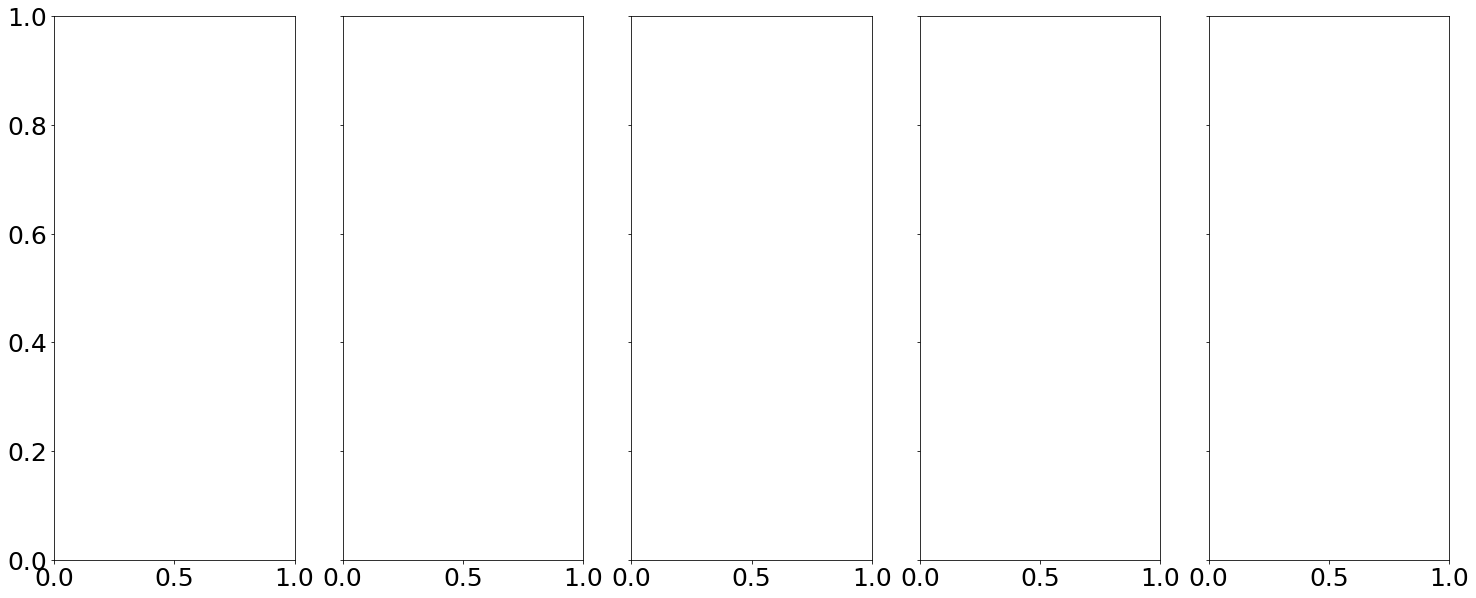

In [59]:
def make_plots(all_res, train_ratios, eval_ratios,save_dir, figname = 'best_sent_acc_all_rep_all_ratio.png',\
               show = True, errorbar = False, option = None):
    fig, axes = plt.subplots(nrows=1, ncols=len(eval_ratios), figsize=(5 * len(eval_ratios),10), sharey=True )
    for j,t_r in enumerate(train_ratios):
        ax = axes[j]
        #all the configuration we need to plot
        num_datas = list(final_res[(train_ratios[0],e_r)].keys())
        all_runs = list(final_res[(train_ratios[0],e_r)][num_datas[0]].keys())
#         print (all_runs)
        n = num_datas[0]
        if option == 'bert_only':
            all_runs = [k for k in all_runs if 'bert' in k]
        else:
            all_runs = [k for k in all_runs if 'bert' in k or '1' in k]
        for k in all_runs:
            linestyle = '--' if 'bert' in k else '-'
            width = 4 if 'bert' in k else 2
            # print (np.asarray([err_bars[(t_r,e_r)][n]['bert_sent']  for n in num_train_datas]).T)
            ys,yerr = [],[]
            for e_r in eval_ratios:
                all_res = final_res[(t_r,e_r)][n][k]
                mean = np.mean(all_res)
                ys.append(mean)
                errs = [mean - np.min(all_res),np.max(all_res) - mean]
                yerr.append(errs)
            yerr = np.asarray(yerr).T
            print (ys)
            if errorbar:
                eb = ax.errorbar(x = [e_r for e_r in eval_ratios], y = ys,yerr= yerr ,\
                label = k,linewidth=2.0, elinewidth = 2.0,capsize = 5,capthick = 1, marker = 'o')
                eb[-1][0].set_linestyle('--')
            else:
                ax.plot([e_r for e_r in eval_ratios], ys,\
                label = k,linewidth=width, marker = 'o' , ls = linestyle)
        ax.set_xlabel('Eval Ratio')
        ax.set_xticks(train_ratios)
        ax.set_title('Train Ratio {}'.format(t_r))
        handles, labels = ax.get_legend_handles_labels()

    fontP = FontProperties()
    fontP.set_size('small')
    fig.legend(handles, labels, loc='lower right', prop = fontP)
    fig.tight_layout()
    plt.savefig(os.path.join(save_dir,figname))
    if show:
        plt.show()
    print ('finished')
    
save_dir = '/home/xiongyi/dataxyz/experiments/plots/2_4'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
make_plots(all_res = final_res, train_ratios = [0.05,0.15,0.25,0.5], \
           eval_ratios =[0.05, 0.25, 0.5, 0.75, 0.95],save_dir = save_dir, errorbar = False, )
    

[0.933, 0.8949999999999999, 0.882, 0.818, 0.768]
[0.9440000000000002, 0.9000000000000001, 0.8775000000000001, 0.8164999999999999, 0.7715]
[0.9195, 0.8885000000000002, 0.8594999999999999, 0.782, 0.6775]
[0.9424999999999999, 0.9014999999999999, 0.874, 0.837, 0.7965]
[0.9275, 0.8879999999999999, 0.874, 0.8654999999999999, 0.8505]
[0.929, 0.9109999999999999, 0.8855000000000001, 0.8630000000000001, 0.8585]
[0.9345000000000001, 0.9119999999999999, 0.8925000000000001, 0.8879999999999999, 0.8645000000000002]
[0.943, 0.915, 0.9029999999999999, 0.8695, 0.8554999999999999]
[0.922, 0.891, 0.898, 0.8905000000000001, 0.8789999999999999]
[0.9475, 0.892, 0.9, 0.8955, 0.884]
[0.9400000000000001, 0.9179999999999999, 0.908, 0.8879999999999999, 0.889]
[0.923, 0.9305, 0.8955, 0.9094999999999999, 0.8765000000000001]
[0.9369999999999999, 0.9305, 0.9035, 0.8859999999999999, 0.8779999999999999]
[0.9390000000000001, 0.908, 0.914, 0.9, 0.8950000000000001]
[0.9404999999999999, 0.9, 0.907, 0.893, 0.905]
[0.8945000

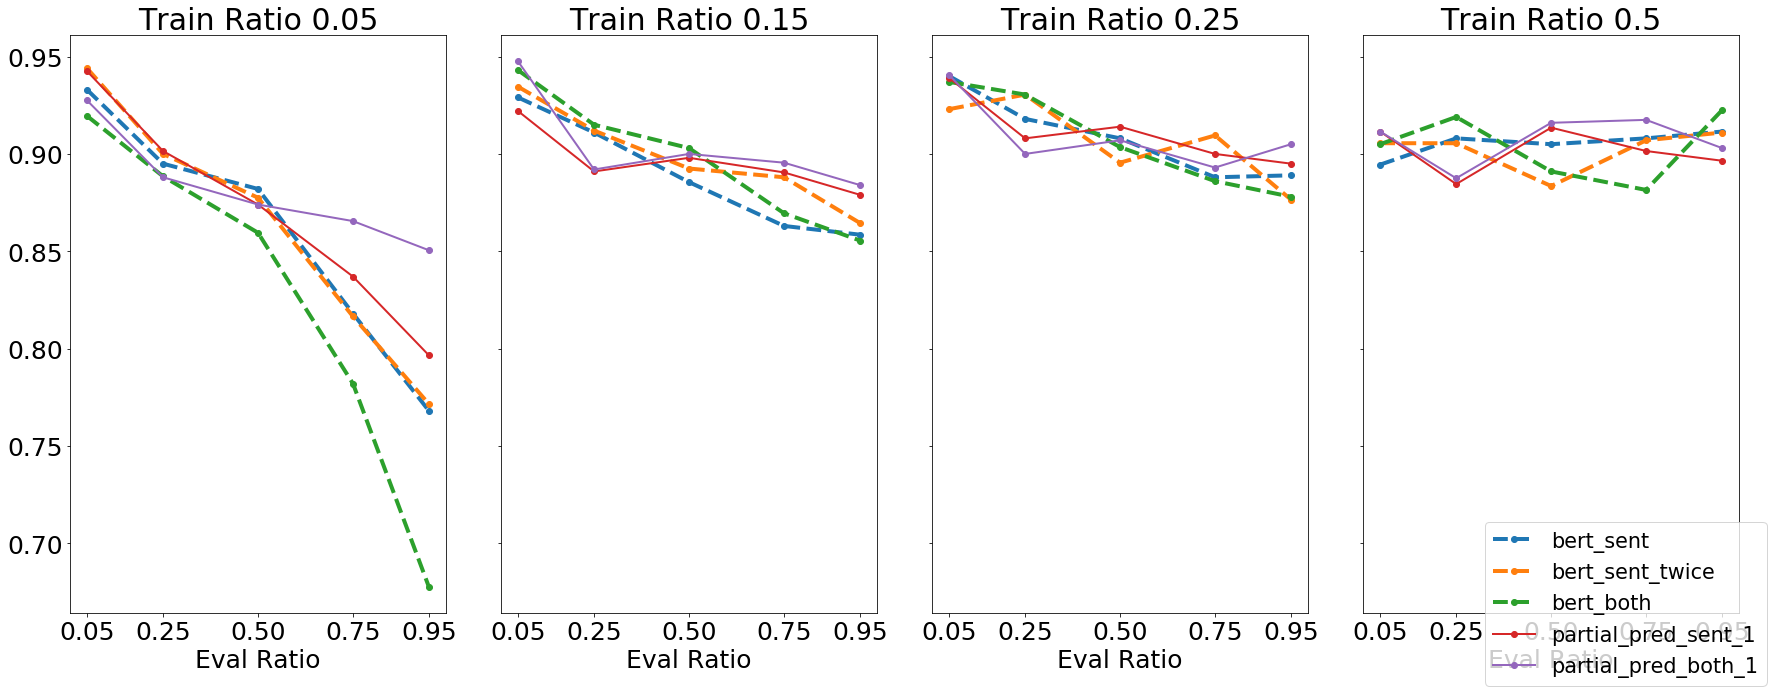

finished


In [66]:
def make_plots_flip(all_res, train_ratios, eval_ratios,save_dir, figname = 'best_sent_acc_all_rep_all_ratio_flip.png',\
               show = True, errorbar = False, option = 'bert_only'):
    fig, axes = plt.subplots(nrows=1, ncols=len(train_ratios), figsize=(5 * len(eval_ratios),10), sharey=True )
    for i,t_r in enumerate(train_ratios):
        ax = axes[i]
        #all the configuration we need to plot
        num_datas = list(final_res[(train_ratios[0],eval_ratios[0])].keys())
        all_runs = list(final_res[(train_ratios[0],eval_ratios[0])][num_datas[0]].keys())
#         print (all_runs)
        n = num_datas[0]
        if option == 'bert_only':
            all_runs = [k for k in all_runs if 'bert' in k]
        else:
            all_runs = [k for k in all_runs if '0' not in k and 'opposite' not in k]
        for k in all_runs:
            linestyle = '--' if 'bert' in k else '-'
            width = 4 if 'bert' in k else 2
            # print (np.asarray([err_bars[(t_r,e_r)][n]['bert_sent']  for n in num_train_datas]).T)
            ys,yerr = [],[]
            for e_r in eval_ratios:
                all_res = final_res[(t_r,e_r)][n][k]
                mean = np.mean(all_res)
                ys.append(mean)
                errs = [mean - np.min(all_res),np.max(all_res) - mean]
                yerr.append(errs)
            yerr = np.asarray(yerr).T
            print (ys)
            if errorbar:
                eb = ax.errorbar(x = [e_r for e_r in eval_ratios], y = ys,yerr= yerr ,\
                label = k,linewidth=2.0, elinewidth = 2.0,capsize = 5,capthick = 1, marker = 'o')
                eb[-1][0].set_linestyle('--')
            else:
                ax.plot([e_r for e_r in eval_ratios], ys,\
                label = k,linewidth=width, marker = 'o', ls = linestyle)
        ax.set_xlabel('Eval Ratio')
        ax.set_xticks(eval_ratios)
        ax.set_title('Train Ratio {}'.format(t_r))
        handles, labels = ax.get_legend_handles_labels()

    fontP = FontProperties()
    fontP.set_size('small')
    fig.legend(handles, labels, loc='lower right', prop = fontP)
    fig.tight_layout()
    plt.savefig(os.path.join(save_dir,figname))
    if show:
        plt.show()
    print ('finished')
    
save_dir = '/home/xiongyi/dataxyz/experiments/plots/2_4'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
make_plots_flip(all_res = final_res, train_ratios = [0.05,0.15,0.25,0.5], \
           eval_ratios =[0.05, 0.25, 0.5, 0.75, 0.95],save_dir = save_dir, errorbar = False, option = None)
    

opposite [0.9383333333333334, 0.9375, 0.9375, 0.9365]
partial [0.9315000000000001, 0.9360000000000002, 0.931, 0.9424999999999999]
opposite [0.8683333333333333, 0.8908333333333335, 0.8941666666666667, 0.9015000000000001]
partial [0.8805, 0.859, 0.874, 0.9014999999999999]
opposite [0.8433333333333334, 0.8483333333333333, 0.8875000000000001, 0.874]
partial [0.818, 0.819, 0.8265, 0.874]
opposite [0.7708333333333334, 0.7925, 0.8391666666666667, 0.8334999999999999]
partial [0.7495, 0.74, 0.762, 0.837]
opposite [0.725, 0.7200000000000001, 0.7941666666666668, 0.787]
partial [0.6759999999999999, 0.6809999999999999, 0.6869999999999999, 0.7965]
opposite [0.93, 0.9308333333333333, 0.9275000000000001, 0.9235]
partial [0.9279999999999999, 0.933, 0.9305, 0.922]
opposite [0.8866666666666667, 0.8866666666666667, 0.8791666666666668, 0.8885]
partial [0.8895, 0.893, 0.8905, 0.891]
opposite [0.8758333333333334, 0.8858333333333333, 0.8758333333333335, 0.89]
partial [0.882, 0.8889999999999999, 0.884500000000

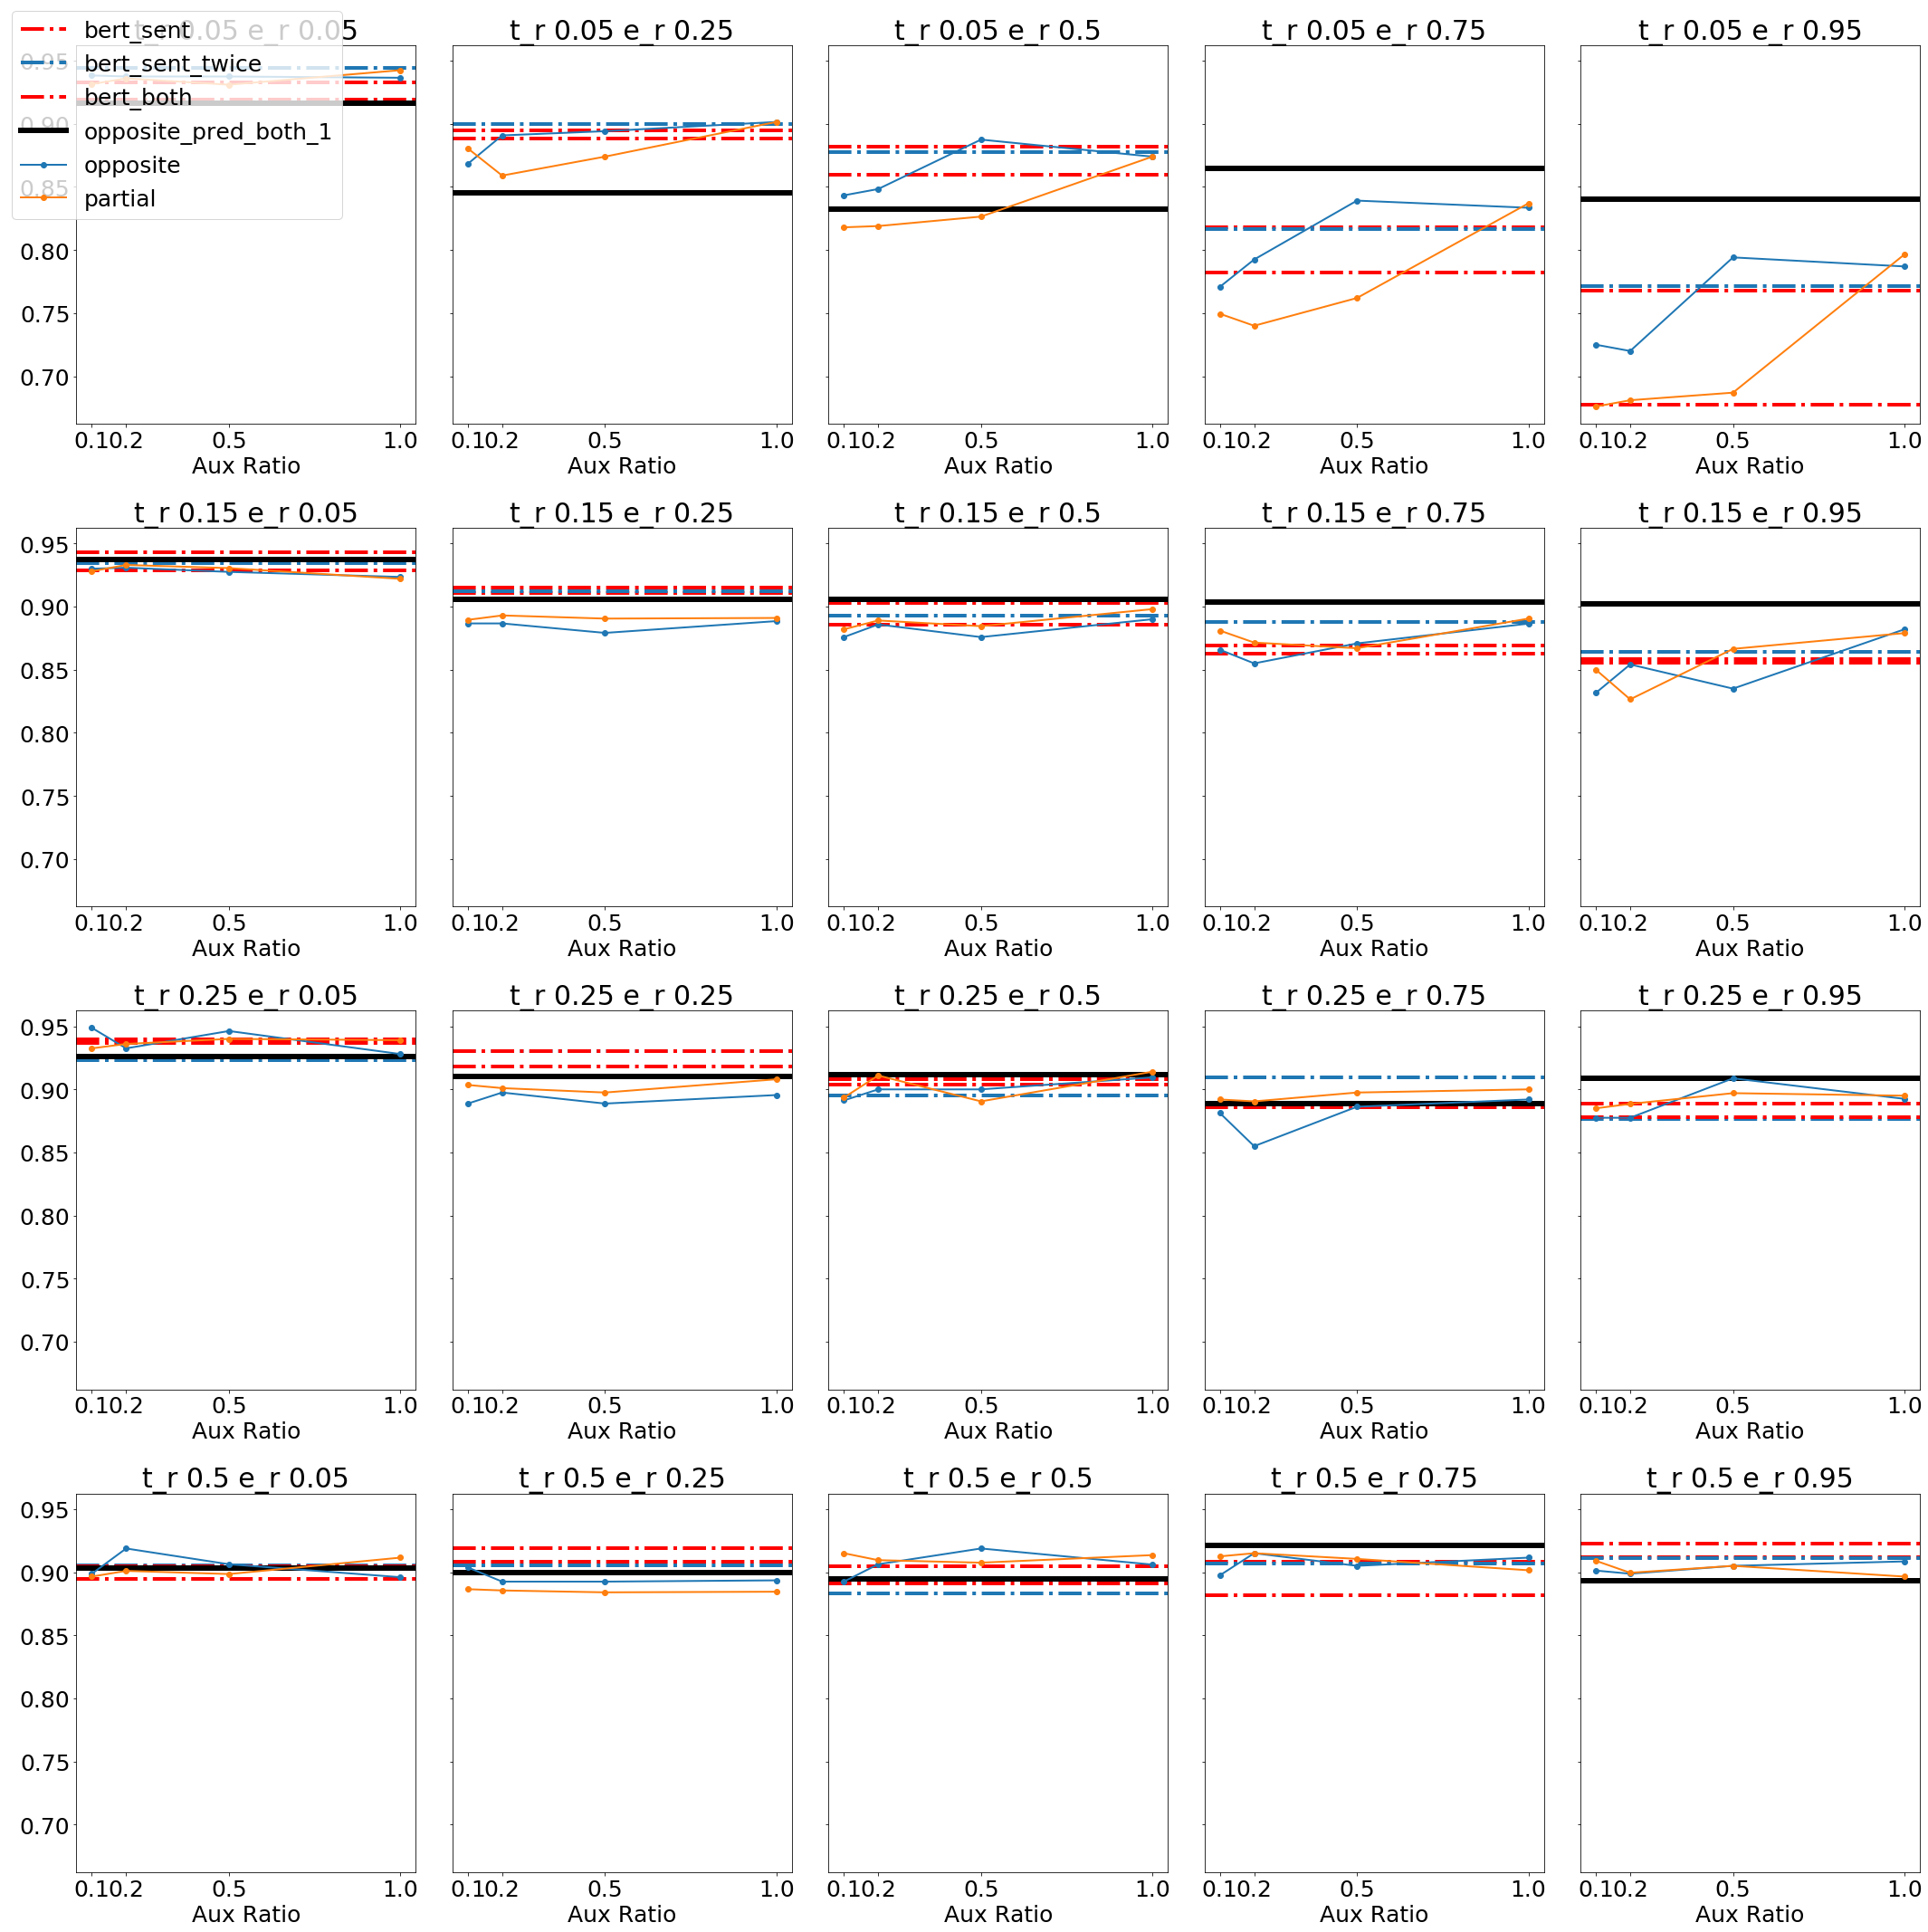

finished


In [24]:
def make_plots_2(all_res, train_ratios, eval_ratios,save_dir, figname = 'best_sent_acc_all_ratio_diff_aux.png',\
               show = True, errorbar = False):
    fig, axes = plt.subplots(nrows=len(train_ratios), ncols=len(eval_ratios), figsize=(30,30), sharey=True )
    for i,t_r in enumerate(train_ratios):
        for j,e_r in enumerate(eval_ratios):
            ax = axes[i,j]
            #all the configuration we need to plot
            num_datas = list(final_res[(train_ratios[0],eval_ratios[0])].keys())
            all_runs = list(final_res[(train_ratios[0],eval_ratios[0])][num_datas[0]].keys())
    #         print (all_runs)
            n = num_datas[0]
            
            #bert_sent
            #bert_sent_twice
            # print (np.asarray([err_bars[(t_r,e_r)][n]['bert_sent']  for n in num_train_datas]).T)
            ys,yerr = [],[]
            all_res = final_res[(t_r,e_r)][n]
            all_runs = list(all_res.keys())
            for a in all_runs:
                if 'bert' in a:
                    if 'twice' in a: 
                        ax.axhline(all_res[a], linestyle='-.', label=a, linewidth=4)
                    else:
                        ax.axhline(all_res[a], linestyle='-.', label=a, color = 'r', linewidth=4)
                        
                elif 'both' in a and 'opposite' in a:
                    ax.axhline(all_res[a], linestyle='-', label=a, color = 'k',linewidth=6)
            aux_ratios = [0.1,0.2,0.5,1]
            for strategy in ['opposite', 'partial']:
                ys = []
                for a_r in aux_ratios:
                    run_name = '{}_pred_sent_{}'.format(strategy, a_r)
                    ys.append(all_res[run_name])
                print (strategy, ys)
                ax.plot(aux_ratios, ys,label = strategy,linewidth=2, marker = 'o', ls = '-')
            
            ax.set_xlabel('Aux Ratio')
            ax.set_xticks(aux_ratios)
            ax.set_title('t_r {} e_r {}'.format(t_r, e_r))
            handles, labels = ax.get_legend_handles_labels()

#     fontP = FontProperties()
#     fontP.set_size('small')
    fig.legend(handles, labels, loc='upper left')
    fig.tight_layout()
    plt.savefig(os.path.join(save_dir,figname))
    if show:
        plt.show()
    print ('finished')
    
save_dir = '/home/xiongyi/dataxyz/experiments/plots/2_5'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
make_plots_2(all_res = final_res, train_ratios = [0.05,0.15,0.25,0.5], \
           eval_ratios =[0.05, 0.25, 0.5, 0.75, 0.95],save_dir = save_dir, errorbar = False, )
    

opposite [0.8758541666666666, 0.8797708333333334, 0.8899166666666668, 0.8917999999999997]
partial [0.8755999999999998, 0.8742749999999999, 0.8773750000000001, 0.8947749999999998]


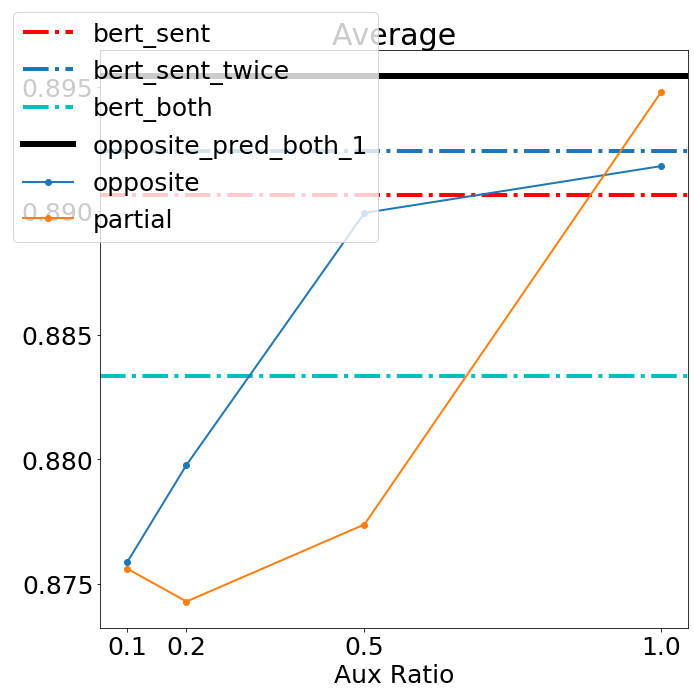

finished


In [11]:
def make_plots_average(all_res, train_ratios, eval_ratios,save_dir, figname = 'average_acc_all_ratio_diff_aux.png',\
               show = True, errorbar = False):
    n = 500
    all_keys = list(final_res[(train_ratios[0],eval_ratios[0])][n].keys())
    
    averages = {k:0 for k in all_keys}
    count = 0
    for i,t_r in enumerate(train_ratios):
        for j,e_r in enumerate(eval_ratios):
            count +=1
            for k in all_keys:
                averages[k] += all_res[t_r,e_r][n][k]
    for k in all_keys:
        averages[k] /= count
    #all the configuration we need to plot
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    
    ys,yerr = [],[]
    all_runs = list(averages.keys())
    for a in all_runs:
        if 'bert' in a:
            if 'twice' in a: 
                ax.axhline(averages[a], linestyle='-.', label=a, linewidth=4)
            elif a == 'bert_both':
                ax.axhline(averages[a], linestyle='-.', label=a, color = 'c', linewidth=4)
            else:
                ax.axhline(averages[a], linestyle='-.', label=a, color = 'r', linewidth=4)

        elif 'both' in a and 'opposite' in a:
            ax.axhline(averages[a], linestyle='-', label=a, color = 'k',linewidth=6)
    aux_ratios = [0.1,0.2,0.5,1]
    for strategy in ['opposite', 'partial']:
        ys = []
        for a_r in aux_ratios:
            run_name = '{}_pred_sent_{}'.format(strategy, a_r)
            ys.append(averages[run_name])
        print (strategy, ys)
        ax.plot(aux_ratios, ys,label = strategy,linewidth=2, marker = 'o', ls = '-')

    ax.set_xlabel('Aux Ratio')
    ax.set_xticks(aux_ratios)
    ax.set_title('Average')
    handles, labels = ax.get_legend_handles_labels()

#     fontP = FontProperties()
#     fontP.set_size('small')
    fig.legend(handles, labels, loc='upper left')
    fig.tight_layout()
    plt.savefig(os.path.join(save_dir,figname))
    if show:
        plt.show()
    print ('finished')
    
save_dir = '/home/xiongyi/dataxyz/experiments/plots/2_5'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
make_plots_average(all_res = final_res, train_ratios = [0.05,0.15,0.25,0.5], \
           eval_ratios =[0.05, 0.25, 0.5, 0.75, 0.95],save_dir = save_dir, errorbar = False, )
    

In [27]:
final_res[0.05,0.05][500]

{'bert_sent': 0.933,
 'bert_sent_twice': 0.9440000000000002,
 'bert_both': 0.9195,
 'opposite_pred_sent_0.1': 0.9383333333333334,
 'opposite_pred_sent_0.2': 0.9375,
 'opposite_pred_sent_0.5': 0.9375,
 'opposite_pred_sent_1': 0.9365,
 'opposite_pred_both_1': 0.916,
 'partial_pred_sent_0': 0.9355,
 'partial_pred_sent_0.1': 0.9315000000000001,
 'partial_pred_sent_0.2': 0.9360000000000002,
 'partial_pred_sent_0.5': 0.931,
 'partial_pred_sent_1': 0.9424999999999999,
 'partial_pred_both_1': 0.916}